Master Thesis Machine Learing  
Gwen Hirsch  
2022

# Evaluate model performances and create plots

#### imports and variable definitions

In [1]:
#own imports
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import networkx as nx
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import pytz
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from scipy.stats import rv_histogram
import gc
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000
import properscoring as ps

#acd imports
from __future__ import division
from __future__ import print_function
from collections import defaultdict
import time
import argparse
import os
import math
import itertools
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from torch.optim import lr_scheduler
from abc import abstractmethod

C:\ProgramData\Anaconda3\envs\base2\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# lists that contain subsets of names later needed for filtering the dataframe columns
# columns I want to predict
vars_of_interest = ['load_actual', 'solar_generation', 'wind_generation' , 'price_day_ahead']

# countries to include in dataset
prefixes = ['DE_', 'FR_', 'CH_', 'GB_']

# lists of the columns with variables of interest
cols_of_interest = [prefix+var for prefix in prefixes for var in vars_of_interest]
cols_of_interest_DE = ['DE_'+var for var in vars_of_interest]
cols_of_interest_FR = ['FR_'+var for var in vars_of_interest]
cols_of_interest_CH = ['CH_'+var for var in vars_of_interest]
cols_of_interest_GB = ['GB_'+var for var in vars_of_interest]

# lists of the columns with weather variables
vars_weather = ['temperature', 'radiation_direct_horizontal', 'radiation_diffuse_horizontal']
cols_weather = [prefix+var for prefix in prefixes for var in vars_weather]
cols_weather_DE = ['DE_'+var for var in vars_weather]
cols_weather_FR = ['FR_'+var for var in vars_weather]
cols_weather_CH = ['CH_'+var for var in vars_weather]
cols_weather_GB = ['GB_'+var for var in vars_weather]

# all 7 quantities to predict
vars_predict = vars_of_interest+vars_weather

# save time column names
cols_time = ['year', 'month', 'day', 'hour', 'weekday']

# save column names in lists and with different orders for plotting...
# ...according to countries
all_vars_of_interest = [prefix+var for prefix in prefixes for var in vars_of_interest+vars_weather]
all_vars_of_interest_DE = cols_of_interest_DE + cols_weather_DE
all_vars_of_interest_FR = cols_of_interest_FR + cols_weather_FR
all_vars_of_interest_CH = cols_of_interest_CH + cols_weather_CH
all_vars_of_interest_GB = cols_of_interest_GB + cols_weather_GB

# ...according to variables
all_vars_of_interest_varfirst = [prefix+var for var in vars_of_interest+vars_weather for prefix in prefixes]

# all original columns in final dataset
all_cols_to_keep     = ['utc_timestamp']+ all_vars_of_interest +cols_time
all_cols_to_keep_DE  = ['utc_timestamp']+ [var for var in all_vars_of_interest if var.startswith('DE_')] +cols_time
all_cols_to_keep_FR  = ['utc_timestamp']+ [var for var in all_vars_of_interest if var.startswith('FR_')] +cols_time
all_cols_to_keep_CH  = ['utc_timestamp']+ [var for var in all_vars_of_interest if var.startswith('CH_')] +cols_time
all_cols_to_keep_GB  = ['utc_timestamp']+ [var for var in all_vars_of_interest if var.startswith('GB_')] +cols_time

# used in dataset generation
# contains all aditional time features 
cols_ts_DE = all_vars_of_interest_DE
cols_ts_FR = all_vars_of_interest_FR
cols_ts_CH = all_vars_of_interest_CH
cols_ts_GB = all_vars_of_interest_GB
cols_ts_all = all_vars_of_interest
cols_ts_long = vars_of_interest+vars_weather
cols_to_cycle = ['month', 'day', 'hour', 'weekday']
cols_timedims_cycle = [timedim+version for timedim in cols_to_cycle for version in ['_sin', '_cos']]
cols_to_normalize_DE = cols_ts_DE+['year']
cols_to_normalize_all = cols_ts_all+['year']
cols_to_normalize_long = cols_ts_long+['year', 'ID']

idx_firstmonday = 96
idx_lastsunday = 43775

In [3]:
# labels for correlation matrix

# labels if correlation matrix is done for Germany only
labels_vars_full = {}
for v in all_vars_of_interest:
    if 'load_actual' in v:
        labels_vars_full[v] = (v.partition('_')[0]+' total load', '[GW]')
    elif 'load_forecast' in v:
        labels_vars_full[v] = (v.partition('_')[0]+' load forecast', '[GW]')
    elif 'solar_generation' in v:
        labels_vars_full[v] = (v.partition('_')[0]+' solar generation', '[GW]')
    elif 'wind_generation' in v:
        labels_vars_full[v] = (v.partition('_')[0]+' wind generation', '[GW]')
    elif 'price_day_ahead' in v:
        if v.partition('_')[0] != 'GB':
            labels_vars_full[v] = (v.partition('_')[0]+' price day-ahead', '[EUR]')
        else:
            labels_vars_full[v] = (v.partition('_')[0]+' price day-ahead', '[GBP]')
    elif 'temperature' in v:
        labels_vars_full[v] = (v.partition('_')[0]+' temperature', '[°C]')
    elif 'radiation_direct_horizontal' in v:
        labels_vars_full[v] = (v.partition('_')[0]+' radiation direct', '[W/m²]')
    elif 'radiation_diffuse_horizontal' in v:
        labels_vars_full[v] = (v.partition('_')[0]+' radiation diffuse', '[W/m²]')
        
labels_vars_virtual = {}
for v in vars_predict:
    if 'load_actual' in v:
        labels_vars_virtual[v] = ('total load', '[GW]')
    elif 'load_forecast' in v:
        labels_vars_virtual[v] = ('load forecast', '[GW]')
    elif 'solar_generation' in v:
        labels_vars_virtual[v] = ('solar generation', '[GW]')
    elif 'wind_generation' in v:
        labels_vars_virtual[v] = ('wind generation', '[GW]')
    elif 'price_day_ahead' in v:
        if v.partition('_')[0] != 'GB':
            labels_vars_virtual[v] = ('price day-ahead', '[EUR]')
        else:
            labels_vars_virtual[v] = ('labels_vars_virtual', '[GBP]')
    elif 'temperature' in v:
        labels_vars_virtual[v] = ('temperature', '[°C]')
    elif 'radiation_direct' in v:
        labels_vars_virtual[v] = ('radiation direct', '[W/m²]')
    elif 'radiation_diffuse' in v:
        labels_vars_virtual[v] = ('radiation diffuse', '[W/m²]')
        
# labels if correlation matrix is done for all countries
labels_vars_short = {}
for v in all_vars_of_interest:
    if 'load_actual' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' LO', '[GW]')
    elif 'solar_generation' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' SO', '[GW]')
    elif 'wind_generation' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' WI', '[GW]')
    elif 'price_day_ahead' in v:
        if v.partition('_')[0] != 'GB':
            labels_vars_short[v] = (v.partition('_')[0]+' PR', '[EUR]')
        else:
            labels_vars_short[v] = (v.partition('_')[0]+' PR', '[GBP]')
    elif 'temperature' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' TE', '[°C]')
    elif 'radiation_direct_horizontal' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' R1', '[W/m²]')
    elif 'radiation_diffuse_horizontal' in v:
        labels_vars_short[v] = (v.partition('_')[0]+' R2', '[W/m²]')

In [4]:
dimgray = np.array(colors.to_rgba('dimgray'))
lightgray = np.array(colors.to_rgba('lightgrey'))
gray = np.array(colors.to_rgba('grey'))
black = np.array(colors.to_rgba('black'))
white = np.array(colors.to_rgba('white'))
darkdimgray = (dimgray+black)/2
darkorange = np.array(colors.to_rgba('darkorange'))
green = np.array(colors.to_rgba('green'))
dodgerblue = np.array(colors.to_rgba('dodgerblue'))

# colors partially from cm.paired and set1
dark_blue    = np.array([0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0])
light_blue   = np.array([0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0])
dark_green   = np.array([0.30196078431372547, 0.6862745098039216, 0.2901960784313726, 1.0])
light_green  = np.array([0.6980392156862745, 0.8745098039215686, 0.5411764705882353, 1.0])
dark_orange  = np.array([1.0, 0.4980392156862745, 0.0, 1.0])
light_orange = np.array([0.9921568627450981, 0.7490196078431373, 0.43529411764705883, 1.0])
dark_purple  = np.array([0.41568627450980394, 0.23921568627450981, 0.6039215686274509, 1.0])
light_purple = np.array([0.792156862745098, 0.6980392156862745, 0.8392156862745098, 1.0])


palette='bright'
snspalette = sns.color_palette(palette, n_colors=7)
snspalette = [np.array(list(elt)+[0]) for elt in snspalette]
color_code_snspalette = {'load_actual': snspalette[0],
                    'solar_generation': snspalette[1],
                    'wind_generation': snspalette[2],
                    'price_day_ahead': snspalette[4],
                    'temperature': snspalette[3],
                    'radiation_direct_horizontal': snspalette[5], 
                    'radiation_diffuse_horizontal': snspalette[6]
                   }

#### settings for training runs

In [5]:
# choose dataset
# suffix = "_energy_DE_1d"
# suffix = "_energy_all_1d"
suffix = "_energy_long_1d"
# suffix = "_energy_DE_7d"
# suffix = "_energy_all_7d"
# suffix = "_energy_long_7d"

# choose acd version -> either a gcn encoder or variational distribution
# version = 'gcn'
version = 'variational'

# whether to make predictions with ACD model
predict_acd = False
# predict_acd = True

# whether to make predictions with ACD with random graphs
predict_rnd = False
# predict_rnd = True

# whether to make predictions with MLR baseline
predict_mlr = False
# predict_mlr = True

# whether to make predictions with LSTM baseline
predict_rnn = False
# predict_rnn = True

# further settings
epochs = 100
batch_size = 16
no_cuda = False
# no_cuda=True

# whether to save the prediction csv
save_pred_csv = False
# save_pred_csv = True

# load csv containing all predictions for the above specified dataset
load_pred_csv = False
load_pred_csv = True

# load all preds
load_allpreds = False
# load_allpreds = True

# whether to to calculate crps scores
do_calc_crps = False
# do_calc_crps = True

# whether to combine preds from same datasets into 3 large csv files
create_country_dfs = False
# create_country_dfs = True

# whether to instead load these preds for plotting
load_country_dfs = False
load_country_dfs = True

# show plots or not
show_figure=True
show_figure=False


## Specify settings and load normed dataframes

.npy input files for acd have shape  
[num_samples, num_ts, num_timesteps, num_dims]   
e.g. [3*365, 7, 24/48, 1+num_features]  
(in acd code [num_sims, num_atoms, num_timesteps, num_dims]) 

#### function definitions

In [6]:
def denormalize_columns(df_norm, save_folder="data/", suffix=""):
    ''' Takes normalized dataframe and saved normalization parameters to arrive at the origianl data.
    
    Parameters
    ----------
    
    df_norm: normed dataframe
    
    save_folder: where should the normalization parameters be retrieved from
    
    suffix: whats the name of the file
    
    Return
    ------
    
    df: denormalized dataframe
    '''
    df=df_norm.copy()
    df_norm_params = pd.read_csv(save_folder + 'norm_params' + suffix + '.csv')
    cols_to_denormalize = df_norm_params['cols']
    # pred_cols = [col.removesuffix('_pred') for col in df.columns if col.endswith('_pred')]
    cols_df = df.columns.values
    
    for col_df in cols_df:
        for col_to_denormalize in cols_to_denormalize:
            if col_df.startswith(col_to_denormalize):
                col_min = df_norm_params.loc[df_norm_params['cols'] == col_to_denormalize, 'min'].values[0]
                col_max = df_norm_params.loc[df_norm_params['cols'] == col_to_denormalize, 'max'].values[0]
                df[col_df] = denormalize(df[col_df], col_min, col_max)
        # if col in pred_cols:
        #     df[col+"_pred"] = denormalize(df[col+'_pred'], col_min, col_max)
            
    return df      
    
def generate_df(df_norm, pred, cols_ts, lstm_format=False, pred_name='_pred'):
    ''' Takes normed prediction from model and adds it as columns to normed dataframe
    
    Parameters
    ----------
    
    df_norm: normed dataframe
    
    pred: model prediction in the form of an array
    
    cols_ts: list with names of the predicted columns
    
    Return
    ------
    
    df_norm: normed dataframe with prediction
    '''
    
    if not lstm_format:
        zero_row = torch.zeros((1, pred.shape[1], pred.shape[2], pred.shape[3]))
    else:
        zero_row = torch.zeros((1, pred.shape[1], pred.shape[2]))
    pred = torch.cat((zero_row,pred.cpu()), dim=0)

    for i, col in enumerate(cols_ts):
        if not lstm_format:
            col_pred = pred[:, i, :, 0]
            col_pred = col_pred.flatten().tolist()
        else:
            col_pred = [0]+pred[:, :, i].squeeze().tolist()
            
        df_norm[col+pred_name] = col_pred
    
    return df_norm

#### load dataframe and norm params

In [7]:
if suffix == "_energy_DE_1d":
    num_samples_train = 3*365+1 
    num_samples_valid = 365
    num_samples_test = 365
    cols_ts = cols_ts_DE
    cols_timedims = ['year']+cols_timedims_cycle
    num_ts = len(cols_ts)
    num_timesteps = 24
    num_dims = 1 +len(cols_timedims)
    dataframe = pd.read_csv('data/normed' +suffix+'.csv', parse_dates=['utc_timestamp'])
    df_norm_params = pd.read_csv('data/norm_params' +suffix+'.csv')
    
if suffix == "_energy_all_1d":
    num_samples_train = 3*365+1 
    num_samples_valid = 365
    num_samples_test = 365
    cols_ts = cols_ts_all
    cols_timedims = ['year']+cols_timedims_cycle
    num_ts = len(cols_ts)
    num_timesteps = 24
    num_dims = 1 +len(cols_timedims)
    dataframe = pd.read_csv('data/normed' +suffix+'.csv', parse_dates=['utc_timestamp'])
    df_norm_params = pd.read_csv('data/norm_params' +suffix+'.csv')
        
if suffix == "_energy_long_1d":
    num_samples_train = (3*365+1)*len(prefixes)
    num_samples_valid = 365*len(prefixes)
    num_samples_test = 365*len(prefixes)
    cols_ts = cols_ts_long
    cols_timedims = ['year']+cols_timedims_cycle+['ID']
    num_ts = len(cols_ts)
    num_timesteps = 24
    num_dims = 1 +len(cols_timedims)
    dataframe = pd.read_csv('data/normed' +suffix+'.csv', parse_dates=['utc_timestamp'])
    df_norm_params = pd.read_csv('data/norm_params' +suffix+'.csv')
        
if suffix == "_energy_DE_7d":
    num_samples_train = 3*52
    num_samples_valid = 52
    num_samples_test = 52
    cols_ts = cols_ts_DE
    cols_timedims = ['year']+cols_timedims_cycle
    num_ts = len(cols_ts)
    num_timesteps = 24*7
    num_dims = 1 +len(cols_timedims)
    idx_start = idx_firstmonday
    idx_end = idx_firstmonday+260*7*24    
    dataframe = pd.read_csv('data/normed' +suffix+'.csv', parse_dates=['utc_timestamp'])
    df_norm_params = pd.read_csv('data/norm_params' +suffix+'.csv')
        
if suffix == "_energy_all_7d":
    num_samples_train = 3*52
    num_samples_valid = 52
    num_samples_test  = 52
    cols_ts = cols_ts_all
    cols_timedims = ['year']+cols_timedims_cycle
    num_ts = len(cols_ts)
    num_timesteps = 24*7
    num_dims = 1 + len(cols_timedims)
    idx_start = idx_firstmonday
    idx_end = idx_firstmonday+260*7*24    
    dataframe = pd.read_csv('data/normed' +suffix+'.csv', parse_dates=['utc_timestamp'])
    df_norm_params = pd.read_csv('data/norm_params' +suffix+'.csv')
        
if suffix == "_energy_long_7d":
    num_samples_train = 3*52*len(prefixes)
    num_samples_valid = 52*len(prefixes)
    num_samples_test = 52*len(prefixes)
    cols_ts = cols_ts_long
    cols_timedims = ['year']+cols_timedims_cycle+['ID']
    num_ts = len(cols_ts)
    num_timesteps = 24*7
    num_dims = 1 +len(cols_timedims)
    idx_start = idx_firstmonday*len(prefixes)
    idx_end = idx_firstmonday*len(prefixes)+260*7*24*len(prefixes)
    dataframe = pd.read_csv('data/normed' +suffix+'.csv', parse_dates=['utc_timestamp'])
    df_norm_params = pd.read_csv('data/norm_params' +suffix+'.csv')
        

## Model implementations

### -------------------- ACD Code --------------------

This acd implementation is adapted from the original implementation at  
https://github.com/loeweX/AmortizedCausalDiscovery.  
All individual files from there (potentially modified) are stored in ACD_code.py

Optionally, instead of importing the .py file, one can copy the cells from the    
ACD_code_notebook.ipynb in here for easier handling when editing.

In [8]:
from ACD_code import *

#### train.py

In [9]:
# from __future__ import division
# from __future__ import print_function

# from collections import defaultdict

# import time
# import numpy as np
# import torch

# from model.modules import *
# from utils import arg_parser, logger, data_loader, forward_pass_and_eval
# from model import utils, model_loader


def train():
    best_val_loss = np.inf
    best_epoch = 0

    for epoch in range(args.epochs):
        t_epoch = time.time()
        train_losses = defaultdict(list)

        for batch_idx, minibatch in enumerate(train_loader):

            data, relations, temperatures = unpack_batches(args, minibatch)

            optimizer.zero_grad()

            losses, _, _, _ = forward_pass_and_eval(
                args,
                encoder,
                decoder,
                data,
                relations,
                rel_rec,
                rel_send,
                args.hard,
                edge_probs=edge_probs,
                log_prior=log_prior,
                temperatures=temperatures,
            )

            loss = losses["loss"]

            loss.backward()
            optimizer.step()

            train_losses = append_losses(train_losses, losses)

        string = logs.result_string("train", epoch, train_losses, t=t_epoch)
        logs.write_to_log_file(string)
        logs.append_train_loss(train_losses)
        scheduler.step()

        if args.validate:
            val_losses = val(epoch)
            val_loss = np.mean(val_losses["loss"])
            if val_loss < best_val_loss:
                print("Best model so far, saving...")
                logs.create_log(
                    args,
                    encoder=encoder,
                    decoder=decoder,
                    optimizer=optimizer,
                    accuracy=np.mean(val_losses["acc"]),
                )
                best_val_loss = val_loss
                best_epoch = epoch
        elif (epoch + 1) % 100 == 0:
            logs.create_log(
                args,
                encoder=encoder,
                decoder=decoder,
                optimizer=optimizer,
                accuracy=np.mean(train_losses["acc"]),
            )

        logs.draw_loss_curves()

    return best_epoch, epoch


def val(epoch):
    t_val = time.time()
    val_losses = defaultdict(list)

    if args.use_encoder:
        encoder.eval()
    decoder.eval()

    for batch_idx, minibatch in enumerate(valid_loader):

        data, relations, temperatures = unpack_batches(args, minibatch)

        with torch.no_grad():
            losses, _, _, _ = forward_pass_and_eval(
                args,
                encoder,
                decoder,
                data,
                relations,
                rel_rec,
                rel_send,
                True,
                edge_probs=edge_probs,
                log_prior=log_prior,
                testing=True,
                temperatures=temperatures,
            )

        val_losses = append_losses(val_losses, losses)

    string = logs.result_string("validate", epoch, val_losses, t=t_val)
    logs.write_to_log_file(string)
    logs.append_val_loss(val_losses)

    if args.use_encoder:
        encoder.train()
    decoder.train()

    return val_losses


def test(encoder, decoder, epoch):
    args.shuffle_unobserved = False
    # args.prediction_steps = 49
    test_losses = defaultdict(list)

    if args.load_folder == "":
        ## load model that had the best validation performance during training
        if args.use_encoder:
            encoder.load_state_dict(torch.load(args.encoder_file))
        decoder.load_state_dict(torch.load(args.decoder_file))

    if args.use_encoder:
        encoder.eval()
    decoder.eval()

    for batch_idx, minibatch in enumerate(test_loader):

        data, relations, temperatures = unpack_batches(args, minibatch)
        # print(data.shape)
        # print(relations.shape)
        # print(data.size(2))
        # print(args.timesteps)

        with torch.no_grad():
            assert (data.size(2) - args.timesteps) >= args.timesteps

            data_encoder = data[:, :, : args.timesteps, :].contiguous()
            data_decoder = data[:, :, args.timesteps : -1, :].contiguous()

            losses, _, _, _, = forward_pass_and_eval(
                args,
                encoder,
                decoder,
                data,
                relations,
                rel_rec,
                rel_send,
                True,
                data_encoder=data_encoder,
                data_decoder=data_decoder,
                edge_probs=edge_probs,
                log_prior=log_prior,
                testing=True,
                temperatures=temperatures,
            )

        test_losses = append_losses(test_losses, losses)

    string = logs.result_string("test", epoch, test_losses)
    logs.write_to_log_file(string)
    logs.append_test_loss(test_losses)

    logs.create_log(
        args,
        decoder=decoder,
        encoder=encoder,
        optimizer=optimizer,
        final_test=True,
        test_losses=test_losses,
    )




### -------------------- MLR Code --------------------

In [10]:
def run_MLR(df, cols_ts, cols_timedims, 
            num_samples_train=(3*365+1)*24,
            num_samples_valid=365*24, 
            num_samples_test=365*24,
            epochs=100,
            suffix='_energy',
            print_every=100,
            lr=0.1
            ):
    
    num_ts = len(cols_ts)
    len_df = len(df)
    offset_valid = num_samples_train
    offset_test = num_samples_train+num_samples_valid
    linear_regression_models = {}
    test_losses = {}
    for target in cols_ts:
        x_whole = torch.FloatTensor(df.loc[:(len_df-1)-1, cols_ts+cols_timedims].values).T
        y_whole = torch.FloatTensor(df.loc[1:(len_df-1), target].values).T
        
        x_train = torch.FloatTensor(df.loc[0:num_samples_train-1, cols_ts+cols_timedims].values.T)#.values)
        y_train = torch.FloatTensor(df.loc[1:num_samples_train, target].values.T)#.values)
        
        x_valid = torch.FloatTensor(df.loc[offset_valid+0:offset_valid+num_samples_valid-1, 
                                          cols_ts+cols_timedims].values).T
        y_valid = torch.FloatTensor(df.loc[offset_valid+1:offset_valid+num_samples_valid, 
                                          target].values).T        
        
        x_test = torch.FloatTensor(df.loc[offset_test+0:offset_test+num_samples_test-1-1, 
                                          cols_ts+cols_timedims].values).T
        y_test = torch.FloatTensor(df.loc[offset_test+1:offset_test+num_samples_test-1, 
                                          target].values).T
        
        n_predictors = x_train.shape[0]
        A = torch.randn((1, n_predictors), requires_grad=True)
        b = torch.randn(1, requires_grad=True)
        
        optimizer = optim.Adam([A, b], lr=lr)

        for i in range(epochs):
            
            optimizer.zero_grad()
            train_pred = A.mm(x_train) + b
            train_loss = ((train_pred - y_train)**2).sum()/num_samples_train
            train_loss.backward()
            optimizer.step()
            
            valid_pred = A.detach()@x_valid + b.detach()
            val_loss = ((valid_pred - y_valid)**2).sum()/num_samples_valid
            
            if (i+1)%print_every==0:
                string = f"i={i+1} target {target} train_loss {train_loss} val_loss {val_loss}" 
                logs.write_to_log_file(string)
                
        test_pred = A.detach()@x_test + b.detach()
        test_loss = ((test_pred - y_test)**2).sum()/num_samples_test
        test_losses[target]=test_loss.item()
        
        string = f"target = {target}, test loss = {test_loss}" 
        logs.write_to_log_file(string)   
        
        linear_regression_models[target]=(A, b)
        
        df[target+'_pred'] = 0
        df.loc[1:,target+'_pred'] = (A.detach() @ x_whole + b.detach())[0].tolist()
        
    avg_test_loss = np.mean(list(test_losses.values()))
    string = f"average test loss= {avg_test_loss}" 
    logs.write_to_log_file(string)   
    
    return linear_regression_models, df, test_losses, avg_test_loss

def predict_MLR(df, MLR_models, cols_ts, cols_timedims):
    for target in cols_ts:
        pred_len = len(df)-1
        x = torch.FloatTensor(df.loc[0:pred_len-1, cols_ts+cols_timedims].values).T
        y = torch.FloatTensor(df.loc[1:pred_len, target].values).T
        (A, b) = MLR_models[target]
        df[target+'_pred_mlr'] = 0
        df.loc[1:,target+'_pred_mlr'] = (A.detach() @ x + b.detach())[0].tolist()        
    return df

### -------------------- RNN Code --------------------

In [11]:
class RNN_baseline(nn.Module):
    def __init__(self, lstm_layers, input_dim, target_dim, batch_size, hidden_dim, device):
        super(RNN_baseline, self).__init__()
        self.lstm_layers = lstm_layers
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.target_dim = target_dim
        self.device = device
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.lstm_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.target_dim)
        
    def forward(self, inputs):
        hidden_state = torch.zeros(self.lstm_layers, self.batch_size, self.hidden_dim).to(self.device)
        cell_state = torch.zeros(self.lstm_layers, self.batch_size, self.hidden_dim).to(self.device)
        hidden = (hidden_state, cell_state)
        
        outputs, hidden = self.lstm(inputs)
        
        return self.linear(outputs).squeeze()

In [12]:
def train_rnn(args):
    best_val_loss = np.inf
    best_epoch = 0

    for epoch in range(args.epochs):
        t_epoch = time.time()
        train_losses = defaultdict(list)
        
        (train_loader, 
         valid_loader,
         test_loader,
         loc_max,
         loc_min,
         vel_max,
         vel_min,
        ) = load_data(args)

        for batch_idx, minibatch in enumerate(train_loader):
            
            data, target, _ = unpack_batches(args, minibatch)

            optimizer.zero_grad()
            
            losses, output = forward_pass_rnn(
                args,
                rnn,
                data,
                target)

            loss = losses["loss_mse"]

            loss.backward()
            optimizer.step()
    
            train_losses = append_losses(train_losses, losses)

        string = logs.result_string("train", epoch, train_losses, t=t_epoch)
        logs.write_to_log_file(string)
        logs.append_train_loss(train_losses)
        scheduler.step()

        if args.validate:
            val_losses = val_rnn(epoch, rnn_args)
            val_loss = np.mean(val_losses["loss_mse"])
            if val_loss < best_val_loss:
                print("Best model so far, saving...")
                logs.create_log(
                    rnn_args,
                    rnn=rnn,
                    optimizer=optimizer,
                )
                best_val_loss = val_loss
                best_epoch = epoch
        elif (epoch + 1) % 100 == 0:
            logs.create_log(
                rnn_args,
                rnn=rnn,
                optimizer=optimizer,
            )

        logs.draw_loss_curves()

    return best_epoch, epoch


def val_rnn(epoch, args):
    t_val = time.time()
    val_losses = defaultdict(list)

    rnn.eval()

    for batch_idx, minibatch in enumerate(valid_loader):

        data, target, _ = unpack_batches(args, minibatch)

        with torch.no_grad():
            losses, output = forward_pass_rnn(
                args,
                rnn,
                data,
                target
            )

        val_losses = append_losses(val_losses, losses)

    string = logs.result_string("validate", epoch, val_losses, t=t_val)
    logs.write_to_log_file(string)
    logs.append_val_loss(val_losses)

    rnn.train()

    return val_losses


def test_rnn(rnn, epoch, args):
    test_losses = defaultdict(list)

    if args.load_folder == "":
        ## load model that had the best validation performance during training
        rnn.load_state_dict(torch.load(args.rnn_file))
    
    rnn.eval()    
    
    for batch_idx, minibatch in enumerate(test_loader):

        data, target, _ = unpack_batches(args, minibatch)

        with torch.no_grad():
            losses, output = forward_pass_rnn(
                args,
                rnn,
                data,
                target#.unsqueeze(1)
            )

        test_losses = append_losses(test_losses, losses)

    string = logs.result_string("test", epoch, test_losses)
    logs.write_to_log_file(string)
    logs.append_test_loss(test_losses)

    logs.create_log(   
        args,
        rnn=rnn,
        optimizer=optimizer,
        final_test=True,
        test_losses=test_losses
    )

## Make predictions

### -------------------- ACD predictions --------------------

#### make prediction on whole dataset with final model

In [13]:
training_samples=num_samples_train
test_samples=num_samples_test
timesteps=num_timesteps
num_atoms=num_ts
dims=num_dims
if version == 'gcn':
    dont_use_encoder = False
elif version == 'variational':
    dont_use_encoder = True 

args = parse_args(
    epochs=epochs, 
    training_samples=training_samples, 
    test_samples=test_samples,
    shuffle_traindata=True,
    suffix=suffix,
    timesteps=timesteps,
    num_atoms=num_atoms,
    dims=dims,
    no_cuda=no_cuda,
    dont_use_encoder=dont_use_encoder,
    batch_size=batch_size
)

In [14]:
do_predict = predict_acd
if do_predict:
    if version == 'gcn':
        if   suffix == '_energy_DE_1d':
            current_log = '20221106-171315'
        elif suffix == '_energy_all_1d':
            current_log = '20221106-192314'
        elif suffix == '_energy_long_1d':
            current_log = '20221106-201437'
        elif suffix == '_energy_DE_7d':
            current_log = '20221108-090152'
        elif suffix == '_energy_all_7d':
            current_log = '20221109-155852'
        elif suffix == '_energy_long_7d':
            current_log = '20221108-105258'
        args.encoder_file = 'logs\\'+current_log+'\\encoderfinal.pt'
    elif version == 'variational':
        if   suffix == '_energy_DE_1d':
            current_log = '20221109-163905'
        elif suffix == '_energy_all_1d':
            current_log = '20221109-165322'
        elif suffix == '_energy_long_1d':
            current_log = '20221109-174204'
        elif suffix == '_energy_DE_7d':
            current_log = '20221109-180817'
        elif suffix == '_energy_all_7d':
            current_log = '20221109-223004'
        elif suffix == '_energy_long_7d':
            current_log = '20221109-212831'
        args.edge_probs_file  = 'logs\\'+current_log+'\\edge_probs_final.pt'
    args.decoder_file = 'logs\\'+current_log+'\\decoderfinal.pt'   
    
    rel_rec, rel_send = create_rel_rec_send(args, args.num_atoms)

    encoder, decoder, optimizer, scheduler, edge_probs = load_model(
        args, None, None, None, None)

    if args.use_encoder:
        encoder.load_state_dict(torch.load(args.encoder_file))
        encoder.eval()
    else:
        edge_probs = torch.load(args.edge_probs_file)

    decoder.load_state_dict(torch.load(args.decoder_file))
    decoder.eval()

    if args.device.type=='cpu':
        encoder = encoder.module.to(args.device)
        decoder = decoder.module.to(args.device)

    data_full = torch.FloatTensor(np.load('data/feat_predict' +suffix+'.npy')).cpu()

    outputs=[]
    adjacency_matrix_list=[]
    losses_list = []
    
    for i in range(int(np.ceil(data_full.shape[0]/batch_size))):
        losses = defaultdict(lambda: torch.zeros((), device=args.device.type))
        
        data = data_full[i*batch_size:(i+1)*batch_size]
        if args.cuda:
            data = data.cuda()
        data_encoder = data[:, :, : args.timesteps, :].contiguous()
        data_decoder = data[:, :, args.timesteps-1 : , :].contiguous()

        if args.use_encoder:
            logits = encoder(data_encoder, rel_rec, rel_send).detach()
        else:
            logits = edge_probs.unsqueeze(0).repeat(data_encoder.shape[0], 1, 1)
        edges = gumbel_softmax(logits, tau=args.temp, hard=True)
        prob = my_softmax(logits, -1)
        
        offdiag_indices = get_offdiag_indices(args.num_atoms)
        adjacency_matrix = torch.zeros(edges.size(0), args.num_atoms * args.num_atoms)
        adjacency_matrix[:, offdiag_indices] = edges[:, :, 1].float().cpu()

        adjacency_matrix = adjacency_matrix.view(edges.size(0), args.num_atoms, args.num_atoms)
        adjacency_matrix_list += [adjacency_matrix]

        target = data_decoder[:, :, 1:, :]

        output = decoder(
                    data_decoder,
                    edges,
                    rel_rec,
                    rel_send,
                    args.prediction_steps).detach()

        outputs += [output]
        
        losses["loss_mse"] = F.mse_loss(output, target).item()
        losses_list += [losses]
    df_losses = pd.DataFrame(losses_list)
    losses = dict(df_losses.mean())
    print("Original losses ")
    print(losses) 

    pred = torch.cat(outputs, 0)
    dataframe = generate_df(dataframe, pred, cols_ts, lstm_format=False, pred_name='_pred_acd')
    adjacency_matrices = torch.cat(adjacency_matrix_list)
    
    if save_pred_csv:
        np.save('data/adjacency_' + version + suffix + '.npy', adjacency_matrices.detach().numpy())


#### make prediction with random graphs

In [15]:
do_predict = predict_rnd
if do_predict:
    if version == 'gcn':
        if   suffix == '_energy_DE_1d':
            current_log = '20221106-171315'
        elif suffix == '_energy_all_1d':
            current_log = '20221106-192314'
        elif suffix == '_energy_long_1d':
            current_log = '20221106-201437'
        elif suffix == '_energy_DE_7d':
            current_log = '20221108-090152'
        elif suffix == '_energy_all_7d':
            current_log = '20221109-155852'
        elif suffix == '_energy_long_7d':
            current_log = '20221108-105258'
        args.encoder_file = 'logs\\'+current_log+'\\encoderfinal.pt'
    elif version == 'variational':
        if   suffix == '_energy_DE_1d':
            current_log = '20221109-163905'
        elif suffix == '_energy_all_1d':
            current_log = '20221109-165322'
        elif suffix == '_energy_long_1d':
            current_log = '20221109-174204'
        elif suffix == '_energy_DE_7d':
            current_log = '20221109-180817'
        elif suffix == '_energy_all_7d':
            current_log = '20221109-223004'
        elif suffix == '_energy_long_7d':
            current_log = '20221109-212831'
        args.edge_probs_file  = 'logs\\'+current_log+'\\edge_probs_final.pt'
    args.decoder_file = 'logs\\'+current_log+'\\decoderfinal.pt'

    rel_rec, rel_send = create_rel_rec_send(args, args.num_atoms)

    encoder, decoder, optimizer, scheduler, edge_probs = load_model(
        args, None, None, None, None
    )

    if args.use_encoder:
        encoder.load_state_dict(torch.load(args.encoder_file))
        encoder.eval()
    else:
        edge_probs = torch.load(args.edge_probs_file)

    decoder.load_state_dict(torch.load(args.decoder_file))
    decoder.eval()

    if args.device.type=='cpu':
        encoder = encoder.module.to(args.device)
        decoder = decoder.module.to(args.device)

    data_full = torch.FloatTensor(np.load('data/feat_predict' +suffix+'.npy')).cpu()

    outputs=[]
    outputs_random_edges=[]
    losses_list = []
    losses_random_edges_list = []
    
    for i in range(int(np.ceil(data_full.shape[0]/batch_size))):
        losses = defaultdict(lambda: torch.zeros((), device=args.device.type))
        losses_random_edges = defaultdict(lambda: torch.zeros((), device=args.device.type))

        data = data_full[i*batch_size:(i+1)*batch_size]
        if args.cuda:
            data = data.cuda()
        data_encoder = data[:, :, : args.timesteps, :].contiguous()
        data_decoder = data[:, :, args.timesteps-1 : , :].contiguous()

        if args.use_encoder:
            logits = encoder(data_encoder, rel_rec, rel_send).detach()
        else:
            logits = edge_probs.unsqueeze(0).repeat(data_encoder.shape[0], 1, 1)
        edges = gumbel_softmax(logits, tau=args.temp, hard=True)
        prob = my_softmax(logits, -1)

        offdiag_indices = get_offdiag_indices(args.num_atoms)

        target = data_decoder[:, :, 1:, :]
                      
        random_logits = torch.FloatTensor(np.random.uniform(torch.min(logits).cpu().detach().numpy(), 
                                          torch.max(logits).cpu().detach().numpy(), size=logits.shape))
        random_edges = gumbel_softmax(random_logits, tau=args.temp, hard=True)
        random_prob = my_softmax(random_logits, -1)

        output_random_edges = decoder(
                    data_decoder,
                    random_edges,
                    rel_rec,
                    rel_send,
                    args.prediction_steps).detach()
        outputs_random_edges += [output_random_edges]
        
        losses_random_edges["loss_mse"] = F.mse_loss(output_random_edges, target)
        losses_random_edges_list += [losses_random_edges]
    df_losses_random_edges = pd.DataFrame(losses_random_edges_list)
    losses_random_edges = dict(df_losses_random_edges.mean())
    print("Losses with random edges ")
    print(losses_random_edges)  

    pred_random_edges = torch.cat(outputs_random_edges, 0)
    dataframe = generate_df(dataframe, pred_random_edges, cols_ts, pred_name='_pred_rnd')
    # df_pred_random_edges = denormalize_columns(df_norm_random_edges, suffix=suffix)


### -------------------- MLR predictions --------------------

#### make prediction on whole dataset with final model

In [16]:
mlr_args = parse_args(
    epochs=epochs,
    training_samples=num_samples_train*num_timesteps, 
    test_samples=num_samples_test*num_timesteps,
    shuffle_traindata=True,
    suffix=suffix+'_MLR',
    timesteps=1,
    num_atoms=num_ts,
    dims=num_dims,
    no_cuda=no_cuda,
    dont_use_encoder=dont_use_encoder,
    batch_size=batch_size
)

In [17]:
if predict_mlr:
    if   suffix.startswith('_energy_DE'):
        current_log = '20221213-203817'
    elif suffix.startswith('_energy_all'):
        current_log = '20221213-203954'
    elif suffix.startswith('_energy_long'):
        current_log = '20221213-204054'
    mlr_args.mlr_file = 'logs\\'+current_log+"\MLR_models"+suffix[:-3]+".npy"

    MLR_models_loaded = np.load(mlr_args.mlr_file,allow_pickle='TRUE').item()
    
    dataframe = predict_MLR(dataframe, MLR_models_loaded, cols_ts, cols_timedims)
# df_MLRpred2 = denormalize_columns(df_MLRpred2, suffix=suffix)
# display(dataframe.head())


### -------------------- RNN predictions --------------------

#### make prediction on whole dataset with final model

In [18]:
if predict_rnn:
        # suffix = suffix[:-3]+'_lstm'
        num_samples_train = num_samples_train*num_timesteps
        num_samples_valid = num_samples_valid*num_timesteps
        num_samples_test = num_samples_test*num_timesteps
        num_dims = num_ts + len(cols_timedims)
        num_timesteps=1

training_samples=num_samples_train
test_samples=num_samples_test
timesteps=num_timesteps
num_atoms=num_ts
dims=num_dims
lstm_layers = 1
input_dim = num_atoms+len(cols_timedims)
target_dim = num_atoms
hidden_dim = 128

rnn_args = parse_args(
    epochs=epochs, 
    training_samples=training_samples, 
    test_samples=test_samples,
    shuffle_traindata=True,
    suffix=suffix[:-3]+'_lstm',
    timesteps=timesteps,
    num_atoms=num_atoms,
    dims=dims,
    no_cuda=no_cuda,
    dont_use_encoder=dont_use_encoder,
    batch_size=batch_size)

In [19]:
if predict_rnn:
    if   suffix.startswith('_energy_DE'):
        current_log = '20221126-135959'
    elif suffix.startswith('_energy_all'):
        current_log = '20221126-141143'
    elif suffix.startswith('_energy_long'):
        current_log = '20221126-163840'
    rnn_args.rnn_file = 'logs\\'+current_log+'\\rnnfinal.pt'

    rnn = RNN_baseline(lstm_layers, 
                       input_dim, 
                       target_dim, 
                       batch_size, 
                       hidden_dim,
                      rnn_args.device)
    if rnn_args.cuda:
        rnn = rnn.cuda()

    optimizer = optim.Adam(list(rnn.parameters()), lr=rnn_args.lr)
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=rnn_args.lr_decay, 
                                    gamma=rnn_args.gamma)

    rnn.load_state_dict (torch.load(rnn_args.rnn_file))
    rnn.eval()
    
    data_full = torch.FloatTensor(np.load('data/feat_predict' +rnn_args.suffix+'.npy')).cpu()
    target_full = torch.FloatTensor(np.load('data/target_predict' +rnn_args.suffix+'.npy')).cpu()
    
    if 'DE_7d' in suffix or 'all_7d' in suffix:
        print('here???')
        data_full = data_full[idx_firstmonday:(idx_lastsunday-1)]
        target_full = target_full[idx_firstmonday:(idx_lastsunday-1)]
    
    if 'long_7d' in suffix:
        length_factor=4
        data_full = data_full[idx_firstmonday*length_factor:(idx_lastsunday+1)*length_factor-2]
        target_full = target_full[idx_firstmonday*length_factor:(idx_lastsunday+1)*length_factor-2]
    
    outputs=[]
    losses_list = []
    for i in range(int(np.ceil(data_full.shape[0]/batch_size))):
        losses = defaultdict(lambda: torch.zeros((), device=rnn_rgs.device.type))

        data = data_full[i*batch_size:(i+1)*batch_size]
        target = target_full[i*batch_size:(i+1)*batch_size]
        
        if rnn_args.cuda:
            data = data.cuda()
            target = target.cuda()

        output = rnn(data).unsqueeze(1)
        target = target

        outputs += [output]
        
    #     losses["loss_mse"] = F.mse_loss(output, target)
    #     losses_list += [losses]
    # df_losses = pd.DataFrame(losses_list)
    # losses = dict(df_losses.mean())
    # print("Original losses ")
    print(losses)  

    pred = torch.cat(outputs, 0)
    # print(len(outputs))
    dataframe = generate_df(dataframe, pred, cols_ts, lstm_format=True, pred_name ='_pred_rnn')
    # df_pred = denormalize_columns(df_norm, suffix=suffix)
    # if save_pred_csv:
    #     df_pred.to_csv('data/rnn_pred_'+ suffix + '.csv', index=False)


## Load CSVs

In [20]:
if save_pred_csv:
    dataframe.to_csv('data/predictions'+ suffix + '_'+version + '.csv', index=False)

if load_pred_csv:
    dataframe = pd.read_csv('data/predictions' +suffix+ '_'+version +'.csv', parse_dates=['utc_timestamp'])

dataframe = dataframe.loc[(num_samples_train+num_samples_valid)*num_timesteps:,:]
print(len(dataframe))

35040


## Calculate errors

In [21]:
def calc_MSE(df, cols_ts, pred_name='_pred_acd'):
    mse_list = []
    for col in cols_ts:
        x = df[col].to_numpy()
        x_pred = df[col+pred_name].to_numpy()
        len_x = len(x)
        mse_col = ((x_pred - x)**2).sum()/len_x
        mse_list += [mse_col]
    mse=np.mean(mse_list)
    return mse

def calc_skill(df, cols_ts, pred_name='_pred_acd'):
    mse_forecast = calc_MSE(df, cols_ts, pred_name)
    mse_ref = calc_MSE(df, cols_ts, pred_name='_pred_mlr')
    skill = 1-mse_forecast/mse_ref
    return skill

def calc_MAE(df, cols_ts, pred_name='_pred_acd'):
    mae_list = []
    for col in cols_ts:
        x = df[col].to_numpy()
        x_pred = df[col+pred_name].to_numpy()
        len_x = len(x)
        mae_col = np.abs(x_pred - x).sum()/len_x
        mae_list += [mae_col]
    mae=np.mean(mae_list)
    return mae

In [22]:
def calc_CRPS(df, cols_ts, pred_name='_pred_acd', show_figure=True,
              save_figure=False, only_figure=False, try_numeric=False,
              plot_name='CRPS_'):
    crps_list = []
    for col in cols_ts:
        print(col)
        
        x = df[col].to_numpy()
        x_pred = df[col+pred_name].to_numpy()
        
        bins=100
        
        xmin = np.min([np.min(x), np.min(x_pred)])
        xmax = np.max([np.max(x), np.max(x_pred)])
        tol=0.01
        
        if 'solar' in col or 'radiation' in col:
            indices_to_keep = np.where(x >= -0.99)[0]
            x = x[indices_to_keep]
            x_pred = x_pred[indices_to_keep]
            tol=0.05
        hist_data = np.histogram(x, bins=bins)
        hist_pred = np.histogram(x_pred, bins=bins)
        
        r_data = rv_histogram(hist_data)
        r_pred = rv_histogram(np.histogram(x_pred, bins=bins))
        
        lower = np.min([np.min(x), np.min(x_pred)])
        upper = np.max([np.max(x), np.max(x_pred)])
        x_values = np.linspace(lower,upper,100)
        r_data_sample = r_data.pdf(x_values)
        r_pred_sample = r_pred.pdf(x_values)
        
        crps_col = 1
        if not only_figure:
            if try_numeric:
                crps_col = ps.crps_quadrature(r_data_sample, r_pred, xmin = xmin, xmax = xmax
                                              , tol = tol
                                             )
                crps_col = np.mean(crps_col)
            else:
                crps_col = ps.crps_quadrature(x, r_pred, xmin = xmin, xmax = xmax
                                              , tol = tol
                                             )
                crps_col = np.mean(crps_col)
        
        if show_figure or only_figure:
            fig, ax = plt.subplots()
            fs=12
            plt.plot(x_values, r_data_sample, label='PDF data')
            plt.plot(x_values, r_pred_sample, label='PDF ACD')
            ax.set_facecolor(color=lightgray)#white)
            ax.tick_params(axis='both', which='major', labelsize=fs)
            plt.legend(loc='upper right', fontsize=fs)
            plt.ylim(bottom=0)
            plt.xlabel('x', fontsize=fs)
            plt.ylabel('P(x)', fontsize=fs)
            crps_result =  ''
            if not only_figure:
                crps_result = ', CRPS = '+str(np.round(crps_col, 3)) 
            labels_vars = labels_vars_full
            if 'long' in plot_name:
                labels_vars = labels_vars_virtual
            ax.set_title(labels_vars[col][0]+crps_result, fontsize=fs)
            plt.gca()
            ax.grid(color='w', linestyle='-')
            if save_figure:
                dpi = fig.get_dpi()
                factor=4
                plt.savefig("plots/crps"+pred_name[-4:]+"/"+plot_name+col+pred_name+".jpg", bbox_inches='tight', dpi=dpi*factor)
            plt.show()
            
        print(crps_col)
        
        crps_list += [np.mean(crps_col)]
    crps = np.mean(crps_list)
    return crps, crps_list

In [23]:
if do_calc_crps:
    pred_name='_pred_acd'
    # pred_name='_pred_rnd'
    cols_error = [col for col in cols_ts for var in vars_of_interest if var in col]    
    try_numeric=True
    # try_numeric=False
    plot_name= 'CRPS'+suffix[7:]+'_'+version+'_'
    crps, crps_list = calc_CRPS(dataframe, cols_error,
                                pred_name = pred_name,
                                show_figure=True, 
                                save_figure=True, 
                                only_figure=False,
                                try_numeric=try_numeric,
                                plot_name=plot_name)
    print(plot_name+pred_name)
    print(np.round(crps, 3))
    print(crps)
    print(crps_list)

In [24]:
if do_calc_crps:
    print(plot_name+pred_name)
    print(np.round(crps, 3))
    print(crps)
    print(crps_list)
    
# CRPS_DE_1d_gcn__pred_acd
# 0.454
# 0.45446718268236197
# [0.27243392124499105, 0.6010017214565841, 0.5134143595126992, 0.4310187285151734]

# CRPS_all_1d_gcn__pred_acd
# 0.538
# 0.5381001711590523
# [0.30933440267233675, 0.4473102657404175, 0.5295711192286578, 0.4738692352579487, 0.5527753024632593, 0.3901372792404163, 0.5344099861473914, 0.6875934728889086, 0.6978378187705733, 0.6080978542089889, 0.7143834015757387, 0.5564387915756605, 0.36485022929689864, 0.6198008675426786, 0.3302064557800891, 0.7929862561548723]

# CRPS_long_1d_gcn__pred_acd
# 0.85
# 0.8495240232873867
# [0.6432965201829526, 1.1404297252853743, 1.1098047992752504, 0.5045650484059699]

# CRPS_DE_7d_gcn__pred_acd
# 0.452
# 0.4524633377425769
# [0.2900535600044421, 0.6628197006695608, 0.4438478321839146, 0.41313225811239024]

# CRPS_all_7d_gcn__pred_acd
# 0.489
# 0.4885586364080369
# [0.3989477873899765, 0.3970110948534627, 0.5170078414766979, 0.433889338157785, 0.5508538811128255, 0.39813586086137376, 0.516382186950765, 0.6033313441028422, 0.46956910622411596, 0.46428847906138043, 0.6897192888547983, 0.45962763955862285, 0.4128633988466182, 0.48746412753386437, 0.36477070686855156, 0.6530761006749102]

# CRPS_long_7d_gcn__pred_acd
# 0.743
# 0.7426931351493793
# [0.535761958796867, 0.9431677611750834, 0.9735202127406866, 0.51832260788488]

# CRPS_DE_1d_variational__pred_acd
# 0.466
# 0.4658145566392282
# [0.3070725098653312, 0.5610995723050224, 0.5306456273565616, 0.46444051702999767]

# CRPS_all_1d_variational__pred_acd
# 0.566
# 0.5663838763957928
# [0.3699089026919278, 0.5456389456044942, 0.5288369965205645, 0.467088872976844, 0.6071105243396644, 0.4669126408712975, 0.5454408015065817, 0.6646724800371974, 0.7106914650393886, 0.7329569054917766, 0.7547014641790157, 0.5445754088303602, 0.3951076282143467, 0.6309626766407217, 0.3368437030718154, 0.760692606316687]

# CRPS_long_1d_variational__pred_acd
# 0.861
# 0.8611935667281285
# [0.7810179689556953, 1.041000808315432, 1.082464190660267, 0.5402912989811199]

# CRPS_DE_7d_variational__pred_acd
# 0.49
# 0.49044659597141077
# [0.3761198236282869, 0.5797862348809066, 0.5362974356861732, 0.4695828896902763]

# CRPS_all_7d_variational__pred_acd
# 0.565
# 0.5650587201535673
# [0.3446236714608004, 0.46056006859350906, 0.5493281859804754, 0.44159893321915855, 0.6468134491380814, 0.45009462780833703, 0.5544616516298121, 0.7330209868063148, 0.6540162230614014, 0.7091008822380911, 0.7583443391820309, 0.5757695420823647, 0.4039345901241161, 0.6254580531806951, 0.3333084948718233, 0.800505823080066]

# CRPS_long_7d_variational__pred_acd
# 0.741
# 0.740699281792291
# [0.541224907977652, 0.9176433443885397, 0.9667757193629152, 0.5371531554400573]

# CRPS_DE_1d_gcn__pred_rnd
# 0.488
# 0.4881817688063123
# [0.4411355017377492, 0.5102402630596765, 0.5225306267992204, 0.478820683628603]

# CRPS_all_1d_gcn__pred_rnd
# 0.256
# 0.25626502984853883
# [0.22856092273036793, 0.2454135460379611, 0.2553122858712047, 0.2864366575501139, 0.25235180702655746, 0.22672746094719165, 0.25899689320802427, 0.28796210292990665, 0.27180307191907416, 0.2374007656741792, 0.28795060043756054, 0.2897284832955482, 0.23165669357693286, 0.2214875028395956, 0.2198961982688774, 0.2985554852635261]

# CRPS_long_1d_gcn__pred_rnd
# 0.842
# 0.841781189055082
# [0.7677538962425753, 1.042963313078347, 1.0415018139944971, 0.5149057329049085]

# CRPS_DE_7d_gcn__pred_rnd
# 0.433
# 0.4327228001542079
# [0.3671019035482409, 0.5934939089258144, 0.41764037486858746, 0.35265501327418874]

# CRPS_all_7d_gcn__pred_rnd
# 0.546
# 0.5459355399857604
# [0.3979816100591825, 0.5602444384186486, 0.5101960696795215, 0.4576127943051778, 0.5840693260143973, 0.48055165446154724, 0.5215733205788645, 0.6293730810913203, 0.4993381385708673, 0.7425839126285428, 0.687869943233202, 0.5241247112063406, 0.4418178122255511, 0.6406483604554642, 0.38592170234643325, 0.6710617644971046]

# CRPS_long_7d_gcn__pred_rnd
# 0.751
# 0.750948587042794
# [0.5194662316405595, 1.0047646889094994, 0.9608501981184421, 0.5187132295026751]

# CRPS_DE_1d_variational__pred_rnd
# 0.426
# 0.4261205946430343
# [0.3229173323257023, 0.4967906653397833, 0.4809249129007529, 0.4038494680058988]

# CRPS_all_1d_variational__pred_rnd
# 0.709
# 0.7091127738198684
# [0.6541982643096058, 0.5839661914616603, 0.7524275660062472, 0.6775260999391771, 0.7611436563780376, 0.5336338938114163, 0.767842046210852, 0.7556879935205449, 0.7071310590316026, 0.7214807919889832, 0.8750291539944461, 0.7272608008965216, 0.6799212100328011, 0.6924292044807281, 0.6230206175646077, 0.8331058314906628]

# CRPS_long_1d_variational__pred_rnd
# 0.775
# 0.7750263547515867
# [0.6469821205765358, 1.0249318551935132, 1.0164266353995552, 0.4117648078367428]

# CRPS_DE_7d_variational__pred_rnd
# 0.382
# 0.38203754957458547
# [0.26446339023424964, 0.5535747329109544, 0.40160323696371203, 0.30850883818942576]

# CRPS_all_7d_variational__pred_rnd
# 0.462
# 0.4624774034323944
# [0.35082377317227825, 0.44289246077251543, 0.4511911563874712, 0.411684364292732, 0.47780440169635713, 0.4087154268326805, 0.4585611891623192, 0.5517892162567205, 0.4216790306437555, 0.5789270917926737, 0.5975868479914535, 0.41369176949139885, 0.3499574056303219, 0.5455121904063988, 0.35691732842752316, 0.5819048019617103]

# CRPS_long_7d_variational__pred_rnd
# 0.593
# 0.5925785078270781
# [0.40206844099208633, 0.8146595966211038, 0.7140200363575008, 0.43956595733762155]


In [25]:
print(suffix+version)
cols_error = [col for col in cols_ts for var in vars_of_interest if var in col]
for predname in ['_pred_acd', '_pred_rnd', '_pred_mlr', '_pred_rnn']:
    print(predname)
    mse = calc_MSE(dataframe, cols_error, pred_name=predname)
    mae =  calc_MAE(dataframe, cols_error, pred_name=predname)
    skill = calc_skill(dataframe, cols_error, pred_name=predname)
    print('MAE: ', np.round(mae, 3))
    print('MSE: ', np.round(mse, 3))
    print('skill: ', np.round(skill, 3))

_energy_long_1dvariational
_pred_acd
MAE:  0.293
MSE:  0.181
skill:  -3.197
_pred_rnd
MAE:  0.319
MSE:  0.217
skill:  -4.031
_pred_mlr
MAE:  0.14
MSE:  0.043
skill:  0.0
_pred_rnn
MAE:  0.255
MSE:  0.143
skill:  -2.305


In [26]:

# _energy_long_1dgcn
# _pred_acd
# MAE:  0.248
# MSE:  0.136
# skill:  -2.154
# _pred_rnd
# MAE:  0.313
# MSE:  0.204
# skill:  -3.726
# _pred_mlr
# MAE:  0.14
# MSE:  0.043
# skill:  0.0
# _pred_rnn
# MAE:  0.255
# MSE:  0.143
# skill:  -2.305


# _energy_all_1dgcn
# _pred_acd
# MAE:  0.141
# MSE:  0.047
# skill:  0.684
# _pred_rnd
# MAE:  0.217
# MSE:  0.105
# skill:  0.296
# _pred_mlr
# MAE:  0.288
# MSE:  0.149
# skill:  0.0
# _pred_rnn
# MAE:  0.087
# MSE:  0.018
# skill:  0.877

# _energy_all_7dgcn
# _pred_acd
# MAE:  0.386
# MSE:  0.257
# skill:  -0.736
# _pred_rnd
# MAE:  0.341
# MSE:  0.208
# skill:  -0.406
# _pred_mlr
# MAE:  0.288
# MSE:  0.148
# skill:  0.0
# _pred_rnn
# MAE:  0.087
# MSE:  0.018
# skill:  0.877

# _energy_long_7dgcn
# _pred_acd
# MAE:  0.119
# MSE:  0.053
# skill:  -0.241
# _pred_rnd
# MAE:  0.196
# MSE:  0.106
# skill:  -1.474
# _pred_mlr
# MAE:  0.14
# MSE:  0.043
# skill:  0.0
# _pred_rnn
# MAE:  0.255
# MSE:  0.142
# skill:  -2.326

# _energy_DE_1dvariational
# _pred_acd
# MAE:  0.12
# MSE:  0.033
# skill:  -1.122
# _pred_rnd
# MAE:  0.275
# MSE:  0.185
# skill:  -10.903
# _pred_mlr
# MAE:  0.089
# MSE:  0.016
# skill:  0.0
# _pred_rnn
# MAE:  0.085
# MSE:  0.015
# skill:  0.023

# _energy_all_1dvariational
# _pred_acd
# MAE:  0.133
# MSE:  0.04
# skill:  0.73
# _pred_rnd
# MAE:  0.429
# MSE:  0.33
# skill:  -1.218
# _pred_mlr
# MAE:  0.288
# MSE:  0.149
# skill:  0.0
# _pred_rnn
# MAE:  0.087
# MSE:  0.018
# skill:  0.877

# _energy_long_1dvariational
# _pred_acd
# MAE:  0.293
# MSE:  0.181
# skill:  -3.197
# _pred_rnd
# MAE:  0.319
# MSE:  0.217
# skill:  -4.031
# _pred_mlr
# MAE:  0.14
# MSE:  0.043
# skill:  0.0
# _pred_rnn
# MAE:  0.255
# MSE:  0.143
# skill:  -2.305

# _energy_DE_7dvariational
# _pred_acd
# MAE:  0.155
# MSE:  0.047
# skill:  -2.064
# _pred_rnd
# MAE:  0.328
# MSE:  0.226
# skill:  -13.61
# _pred_mlr
# MAE:  0.089
# MSE:  0.015
# skill:  0.0
# _pred_rnn
# MAE:  0.085
# MSE:  0.015
# skill:  0.018

# _energy_all_7dvariational
# _pred_acd
# MAE:  0.166
# MSE:  0.057
# skill:  0.614
# _pred_rnd
# MAE:  0.397
# MSE:  0.274
# skill:  -0.853
# _pred_mlr
# MAE:  0.288
# MSE:  0.148
# skill:  0.0
# _pred_rnn
# MAE:  0.087
# MSE:  0.018
# skill:  0.877

# _energy_long_7dvariational
# _pred_acd
# MAE:  0.115
# MSE:  0.039
# skill:  0.098
# _pred_rnd
# MAE:  0.212
# MSE:  0.114
# skill:  -1.667
# _pred_mlr
# MAE:  0.14
# MSE:  0.043
# skill:  0.0
# _pred_rnn
# MAE:  0.255
# MSE:  0.142
# skill:  -2.326


## Plot Time Series, Predictions and Graphs

In [27]:
if create_country_dfs:
    suffixes_DE   = ["_energy_DE_1d_gcn", "_energy_DE_7d_gcn", "_energy_DE_1d_variational", "_energy_DE_7d_variational"]
    suffixes_all  = ["_energy_all_1d_gcn", "_energy_all_7d_gcn", "_energy_all_1d_variational", "_energy_all_7d_variational"] 
    suffixes_long = ["_energy_long_1d_gcn", "_energy_long_7d_gcn", "_energy_long_1d_variational", "_energy_long_7d_variational"]

    if load_allpreds:
        dfs_DE = {}
        dfs_all = {}
        dfs_long = {}
        for s in suffixes_DE:
            df_norm = pd.read_csv('data/predictions' +s+ '.csv', parse_dates=['utc_timestamp'])
            part = '_gcn'
            if 'variational' in s:
                part='_variational'
            df_pred = denormalize_columns(df_norm, suffix=s.partition(part)[0])
            dfs_DE[s] = df_pred
        for s in suffixes_all:
            df_norm = pd.read_csv('data/predictions' +s+ '.csv', parse_dates=['utc_timestamp'])
            part = '_gcn'
            if 'variational' in s:
                part='_variational'
            df_pred = denormalize_columns(df_norm, suffix=s.partition(part)[0])
            dfs_all[s] = df_pred
        for s in suffixes_long:
            df_norm = pd.read_csv('data/predictions' +s+ '.csv', parse_dates=['utc_timestamp'])
            part = '_gcn'
            if 'variational' in s:
                part='_variational'
            df_pred = denormalize_columns(df_norm, suffix=s.partition(part)[0])
            dfs_long[s] = df_pred

    df_DE = dfs_DE['_energy_DE_1d_gcn']
    acd_pred_cols = [col for col in df_DE.columns.values if '_pred_acd' in col]
    acd_pred_cols_names = [col+'_G1' for col in df_DE.columns.values if '_pred_acd' in col]
    name_dict = dict(zip(acd_pred_cols, acd_pred_cols_names))
    df_DE = df_DE.rename(columns=name_dict)
    for s in suffixes_DE[1:]:
        df_DE2 = dfs_DE[s]
        acd_pred_cols = [col for col in df_DE2.columns.values if '_pred_acd' in col]
        for col in acd_pred_cols:
            v = '_G'
            d = '1'
            if 'variational' in s:
                v = '_V'
            if '7d' in s:
                d = '7'
            df_DE[col+v+d] = df_DE2[col]  

    df_all = dfs_all['_energy_all_1d_gcn']
    acd_pred_cols = [col for col in df_all.columns.values if '_pred_acd' in col]
    acd_pred_cols_names = [col+'_G1' for col in df_all.columns.values if '_pred_acd' in col]
    name_dict = dict(zip(acd_pred_cols, acd_pred_cols_names))
    df_all = df_all.rename(columns=name_dict)
    for s in suffixes_all[1:]:
        df_all2 = dfs_all[s]
        acd_pred_cols = [col for col in df_all2.columns.values if '_pred_acd' in col]
        for col in acd_pred_cols:
            v = '_G'
            d = '1'
            if 'variational' in s:
                v = '_V'
            if '7d' in s:
                d = '7'
            df_all[col+v+d] = df_all2[col] 

    df_long = dfs_long['_energy_long_1d_gcn']
    acd_pred_cols = [col for col in df_long.columns.values if '_pred_acd' in col]
    acd_pred_cols_names = [col+'_G1' for col in df_long.columns.values if '_pred_acd' in col]
    name_dict = dict(zip(acd_pred_cols, acd_pred_cols_names))
    df_long = df_long.rename(columns=name_dict)
    for s in suffixes_long[1:]:
        df_long2 = dfs_long[s]
        acd_pred_cols = [col for col in df_long2.columns.values if '_pred_acd' in col]
        for col in acd_pred_cols:
            v = '_G'
            d = '1'
            if 'variational' in s:
                v = '_V'
            if '7d' in s:
                d = '7'
            df_long[col+v+d] = df_long2[col]  

In [28]:
if create_country_dfs:
    df_DE.to_csv('data/df_DE.csv', index=False)
    df_all.to_csv('data/df_all.csv', index=False)
    df_long.to_csv('data/df_long.csv', index=False)
                   
if load_country_dfs:
    df_DE = pd.read_csv('data/df_DE.csv', parse_dates=['utc_timestamp'])
    df_all = pd.read_csv('data/df_all.csv', parse_dates=['utc_timestamp'])
    df_long = pd.read_csv('data/df_long.csv', parse_dates=['utc_timestamp'])
# display(df_DE)
# display(df_all)
# display(df_long)

### -------------------- plot data --------------------

In [29]:
plt.style.use('bmh')
def plot_ts(df_plot, cols_to_plot, labels, 
            plot_pred=True, plot_mean=True, plot_dif=False, 
            datemin=[2015, 1, 1], datemax=[2020, 1, 1], 
            color=None, legend_color=None, pred_color=None,
            bg_color=lightgray, 
            legend_alpha=0.8, legend_text_alpha = 1.0,
            gray_share = 0.25,
            face_color=None, alpha_ts=1, alpha_pred=1,
            avg_color=None, avg_pred_color='white', 
            show_mean=False, time_unit='', do_set_fc=True,
            fs=18, fig_width=20, subplot_height=1.5, 
            save_figure=False, plot_name="plot_ts",
            prefix='DE ', linebreak = '', title='',
            annotate=False):
    
    nplots = len(cols_to_plot)
    
    if color is None:
        color = cm.turbo(np.linspace(0, 1, nplots))[::-1]
        if legend_color is not None:
            color = [black for c in color]
        
    datemin = datetime.datetime(datemin[0], datemin[1], datemin[2], tzinfo=pytz.UTC)
    datemax = datetime.datetime(datemax[0], datemax[1], datemax[2], tzinfo=pytz.UTC)

    fig = plt.figure(figsize=(fig_width, subplot_height*nplots))
    if do_set_fc:
        ax.set_facecolor(color=bg_color)

    for i, col in enumerate(cols_to_plot):
        ax = plt.subplot(nplots, 1, i+1)
        if annotate:
            where = (0.05,0.9)
            ax.annotate(labels[i][0], xy=where, xytext=where, xycoords='axes fraction',
                        fontsize=fs, ha='left', va='bottom',
                        color=white,
                        bbox=dict(boxstyle='round', fc=(1-gray_share)*legend_color[i]+gray_share*gray),
                       )
        myFmt = mdates.DateFormatter('%m-%d')
        ax.xaxis.set_major_formatter(myFmt)
        if col+'_pred_acd_G1' in df_plot.columns:
            ax.plot(df_plot[col+'_pred_acd_G1']
                    , c=light_green
                    , alpha = alpha_pred
                    , linestyle='dashed'
                    , label = 'ACD G1'
                   )
        if col+'_pred_acd_G7' in df_plot.columns:
            ax.plot(df_plot[col+'_pred_acd_G7']
                    , c=dark_green
                    , alpha = alpha_pred
                    , label = 'ACD G7'                
                   )
        if col+'_pred_acd_V1' in df_plot.columns:
            ax.plot(df_plot[col+'_pred_acd_V1']
                    , c=light_orange
                    , alpha = alpha_pred
                    , linestyle='dashed'
                    , label = 'ACD V1'
                   )
        if col+'_pred_acd_V7' in df_plot.columns:
            ax.plot(df_plot[col+'_pred_acd_V7']
                    , c=dark_orange
                    , alpha = alpha_pred
                    , label = 'ACD V7'
                   )
        if col+'_pred_mlr' in df_plot.columns:
            ax.plot(df_plot[col+'_pred_mlr']
                    , c=light_blue
                    , alpha = alpha_pred
                    , label = 'MLR'
                   )
        if col+'_pred_rnn' in df_plot.columns:
            ax.plot(df_plot[col+'_pred_rnn']
                    , c=dark_blue
                    , alpha = alpha_pred
                    , linestyle='dashed'
                    , label = 'LSTM'
                   )
        ax.plot(df_plot[col]
                    , c=color[i]
                    , alpha = alpha_ts
                    , label='data'
                   )

        ax.set_xlim(datemin, datemax)
        ax.set_ylabel(labels[i][1], fontsize=fs)
        ax.tick_params(axis='both', which='major', labelsize=fs-6)
        if any([var in col for var in ['load', 'solar_generation', 'wind_generation']]):
            ticks_loc = ax.get_yticks()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            if labels[i][1] == '[MW]':
                ax.set_yticklabels(['{}'.format(int(tick/1000))+'k' if int(tick)>1000 else '{}'.format(int(tick)) for tick in ticks_loc])
            elif labels[i][1] == '[GW]':
                ax.set_yticklabels([str(int(tick)) for tick in ticks_loc/1000])

        if i < nplots-1:
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('date'+ time_unit, fontsize=fs)
        leg = plt.legend(loc = "upper right", fontsize=fs-6,
                         )
        for text in leg.get_texts():
            text.set_alpha(legend_text_alpha)
    fig.suptitle(title, fontsize=fs+4, y=1)        
    fig.align_ylabels()
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.1)

    factor=8
    if save_figure:
        dpi = fig.get_dpi()
        plt.savefig("plots/"+plot_name+".jpg", bbox_inches='tight', dpi=dpi*factor)
    plt.show()


In [30]:
df_plot = df_DE.set_index('utc_timestamp')
cols_to_plot = cols_of_interest_DE
labels = [labels_vars_full[col] for col in cols_to_plot]
datasetID = '_DE'
title = 'Single country forecasts'

# df_plot = df_all.set_index('utc_timestamp')

# # cols_to_plot = cols_of_interest_DE
# # country='_DE'
# # title = 'Multiple countries forecasts for DE'

# # cols_to_plot = cols_of_interest_FR
# # country='_FR'
# # title = 'Multiple countries forecasts for FR'

# cols_to_plot = cols_of_interest_CH
# country='_CH'
# title = 'Multiple countries forecasts for CH'

# # cols_to_plot = cols_of_interest_GB
# # country='_GB'
# # title = 'Multiple countries forecasts for GB'

# labels = [labels_vars_full[col] for col in cols_to_plot]
# datasetID = '_all'+country


# df_plot = df_long[df_long['ID']==0.0].set_index('utc_timestamp')
# cols_to_plot = vars_of_interest
# labels = [labels_vars_virtual[col] for col in cols_to_plot]
# datasetID = '_long'
# title = 'Virtual country forecast for DE'

# df_plot = df_long[df_long['ID']==1.0].set_index('utc_timestamp')
# cols_to_plot = vars_of_interest
# labels = [labels_vars_virtual[col] for col in cols_to_plot]
# datasetID = '_long'
# title = 'Virtual country forecast for FR'

# df_plot = df_long[df_long['ID']==2.0].set_index('utc_timestamp')
# cols_to_plot = vars_of_interest
# labels = [labels_vars_virtual[col] for col in cols_to_plot]
# datasetID = '_long'
# title = 'Virtual country forecast for CH'

# df_plot = df_long[df_long['ID']==3.0].set_index('utc_timestamp')
# cols_to_plot = vars_of_interest
# labels = [labels_vars_virtual[col] for col in cols_to_plot]
# datasetID = '_long'
# title = 'Virtual country forecast for GB'


color = cm.turbo(np.linspace(0, 1, len(vars_of_interest+vars_weather)))[::-1]
color = list(color)#*len(prefixes)
        
bg_color_error=white

plot_name_base = "pred"
# datemin=[2015, 1, 1]
# datemax=[2020, 1, 1]
datemin=[2019, 5, 1]
datemax=[2019, 6, 1]
# datemin=[2019, 1, 1]
# datemax=[2020, 1, 1]

save_figure=True
# save_figure=False
plot_name=plot_name_base+datasetID
if show_figure:
    plot_ts(df_plot, cols_to_plot=cols_to_plot, labels=labels, 
            color=None, 
            legend_color = color,
            legend_alpha = 1,
            legend_text_alpha = 1,
            gray_share=0.25,#0.25,
            plot_pred=True, 
            datemin=datemin, datemax=datemax, 
            bg_color=lightgray, 
            alpha_ts=1, 
            alpha_pred=0.95,
            avg_color=black,#darkdimgray,
            save_figure=save_figure, plot_name=plot_name,
            show_mean=True, time_unit='', do_set_fc=False,
            fs=22, fig_width=22, subplot_height=5,
            annotate=True,
            title=title
            )

### -------------------- plot graphs --------------------

In [31]:
save_figure=True
# save_figure=False

In [32]:
def show_graph_with_labels(adjacency_matrix, graph_labels, 
                           node_colors=None, edge_colors_dict=None,
                          save_figure = True, plotname='',
                          title=''):

    rows, cols = np.where(adjacency_matrix >= 0.5)
    edges_list = list(zip(rows.tolist(), cols.tolist()))

    edges = zip(rows.tolist(), cols.tolist())
    num_edges = len(edges_list)

    edge_weights = np.array([adjacency_matrix[rows[i],cols[i]] for i in range(num_edges)])
    edge_colors = [edge_colors_dict[edge[0]] for edge in edges_list]
    
    edges = zip(rows.tolist(), cols.tolist())
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    
    G = nx.DiGraph()
    G.add_nodes_from(list(range(len(graph_labels))))
    G.add_edges_from(edges)
    nx.draw_circular(G, 
                     connectionstyle='arc3, rad = 0.05',
                     node_size=500, 
                     labels=graph_labels, 
                     with_labels=True, 
                     arrows=True, 
                     node_color=node_colors,
                     font_color = white,
                     font_size=14,
                     linewidths=5,
                     width=edge_weights*3,
                     # edge_labels=edge_weights,
                     edge_color=edge_colors,
                     arrowsize=14)
    country = 'DE'
    c= 'single country'
    if 'all' in plotname:
        country = 'all'
        c='multiple countries'
    elif 'long' in plotname:
        country='long'
        c='virtual country'
    num_days='1'
    if '7' in plotname:
        num_days='7'
    version = 'G'
    if 'variational' in plotname:
        version='V'
    
    ax.set_title('ACD '+version+num_days+' '+c, fontsize=14)    
        
    factor=8
    if save_figure:
        dpi = fig.get_dpi()
        plt.savefig("plots/Graph_"+country+"_"+suffix+"_"+version+".jpg", bbox_inches='tight', dpi=dpi*factor)
    plt.show()
    

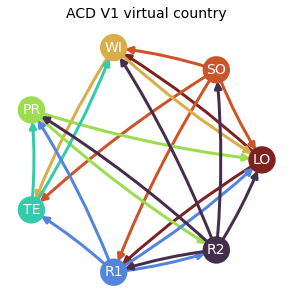

In [36]:
file_name = 'data\\adjacency_'+version+suffix+".npy"
adjacency_matrices = np.load(file_name,allow_pickle='TRUE')
# print(adjacency_matrices.shape)

gray_share=0.25
graph_labels={0:'LO', 1:'SO', 2:'WI', 3:'PR', 4:'TE', 5:'R1', 6:'R2'}

node_colors = cm.turbo(np.linspace(0, 1, len(graph_labels)))[::-1]
node_colors = [((1-gray_share)*color+gray_share*gray) for color in node_colors]

edge_colors = {}
for key in list(graph_labels.keys()):
    edge_colors[key] = node_colors[key]
    
avg_adj = np.mean(adjacency_matrices, axis=0)

#comment out for multiple country version and run following two cells
show_graph_with_labels(avg_adj, graph_labels, 
                       node_colors, edge_colors,
                       plotname=suffix+'_'+version)


In [34]:
# variant for multiple countries
def show_graph_with_labels2(adjacency_matrix, graph_labels, 
                           node_colors=None, edge_colors_dict=None,
                          save_figure = True, plotname='',
                          title=''):

    rows, cols = np.where(adjacency_matrix >= 0.5)
    edges_list = list(zip(rows.tolist(), cols.tolist()))

    edges = zip(rows.tolist(), cols.tolist())
    num_edges = len(edges_list)

    edge_weights = np.array([adjacency_matrix[rows[i],cols[i]] for i in range(num_edges)])
    edge_colors = [edge_colors_dict[edge[0]] for edge in edges_list]
    
    edges = zip(rows.tolist(), cols.tolist())
    
    fig, ax = plt.subplots(figsize=(25,25))
    
    
    G = nx.DiGraph()
    G.add_nodes_from(list(range(len(graph_labels))))
    G.add_edges_from(edges)
    nx.draw_circular(G, 
                     connectionstyle='arc3, rad = 0.05',
                     node_size=1800, 
                     labels=graph_labels, 
                     with_labels=True, 
                     arrows=True, 
                     node_color=node_colors,
                     font_color = white,
                     font_size=14,
                     linewidths=5,
                     width=edge_weights*3,
                     # edge_labels=edge_weights,
                     edge_color=edge_colors,
                     arrowsize=14)
    country = 'DE'
    c= 'single country'
    if 'all' in plotname:
        country = 'all'
        c='multiple countries'
    elif 'long' in plotname:
        country='long'
        c='virtual country'
    num_days='1'
    if '7' in plotname:
        num_days='7'
    version = 'G'
    if 'variational' in plotname:
        version='V'
    
    ax.set_title('ACD '+version+num_days+' '+c, fontsize=14)    
        
    factor=8
    if save_figure:
        dpi = fig.get_dpi()
        plt.savefig("plots/Graph_"+country+"_"+suffix+"_"+version+".jpg", bbox_inches='tight', dpi=dpi*factor)
    plt.show()
    

In [37]:

graph_labels={0:'DE LO', 1:'DE SO', 2:'DE WI', 3:'DE PR', 4:'DE TE', 5:'DE R1', 6:'DE R2',
               7:'FR LO', 8:'FR SO', 9:'FR WI', 10:'FR PR', 11:'FR TE', 12:'FR R1', 13:'FR R2',
              14:'CH LO', 15:'CH SO', 16:'CH WI', 17:'CH PR', 18:'CH TE', 19:'CH R1', 20:'CH R2',
              21:'GB LO', 22:'GB SO', 23:'GB WI', 24:'GB PR', 25:'GB TE', 26:'GB R1', 27:'GB R2',}

node_colors2 = node_colors*4
edge_colors = {}
for key in list(graph_labels.keys()):
    edge_colors[key] = node_colors2[key%7]

# comment in to plot multiple country graphs
# show_graph_with_labels2(avg_adj, graph_labels, 
#                        node_colors2, edge_colors,
#                        plotname=suffix+'_'+version)